In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import seaborn as sns
import csv

from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats

from numpy import mean
from numpy import absolute
from numpy import sqrt

from statsmodels.graphics.tsaplots import plot_acf, plot_predict
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set style for plots

In [257]:
sns.set(style="ticks")
sns.set_style("darkgrid")

## Read data from excel

In [258]:
df = pd.read_excel('combat_losses.xlsx', engine='openpyxl')
df = df.set_index('date')

## Quick look at data

In [259]:
df.tail()

,personnel,tanks,APV,artillery systems,MLRS,anti-aircraft warfare systems,aircraft,helicopters,vehicles,boats / cutters,UAV operational-tactical level,special equipment,mobile SRBM system,cruise missiles
date,,,,,,,,,,,,,,
2022-05-23,29200,1293,3166,604,201,93,204,170,2206,13,476,43,4,110
2022-05-24,29350,1302,3194,606,201,93,205,170,2213,13,480,43,4,112
2022-05-25,29450,1305,3213,606,201,93,206,170,2217,13,491,44,4,112
2022-05-26,29600,1315,3235,617,201,93,206,170,2225,13,502,47,4,114
2022-05-27,29750,1322,3246,623,201,93,206,170,2226,13,503,48,4,115


In [260]:
df.columns

Index(['personnel', 'tanks', 'APV', 'artillery systems', 'MLRS',
       'anti-aircraft warfare systems', 'aircraft', 'helicopters', 'vehicles',
       'boats / cutters', 'UAV operational-tactical level',
       'special equipment', 'mobile SRBM system', 'cruise missiles'],
      dtype='object')

In [261]:
df.describe()

,tanks,APV,artillery systems,MLRS,anti-aircraft warfare systems,aircraft,helicopters,vehicles,boats / cutters,UAV operational-tactical level,special equipment,mobile SRBM system,cruise missiles
count,93.000000,93.000000,93.00000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,744.978495,1969.451613,344.16129,117.666667,58.150538,138.548387,125.935484,1323.817204,7.193548,172.086022,23.311828,2.688172,28.354839
std,362.103276,768.186055,171.30105,56.805605,26.345095,61.440589,43.979196,626.421652,3.865280,163.977110,15.267170,1.876505,44.852814
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,466.000000,1470.000000,213.00000,72.000000,44.000000,95.000000,115.000000,914.000000,3.000000,17.000000,11.000000,0.000000,0.000000
50%,725.000000,1923.000000,347.00000,111.000000,55.000000,154.000000,137.000000,1387.000000,7.000000,119.000000,25.000000,4.000000,0.000000
75%,1077.000000,2610.000000,491.00000,163.000000,81.000000,194.000000,155.000000,1867.000000,10.000000,303.000000,38.000000,4.000000,87.000000
max,1322.000000,3246.000000,623.00000,201.000000,93.000000,206.000000,170.000000,2226.000000,13.000000,503.000000,48.000000,4.000000,115.000000


## Functions to handle data approximation
As we see, we have approximate data in personnel losses such as 'less than' or 'more than'.

To handle it we use average losses between 2 war days.

In [262]:
def handle_error(el):
    if str(el)[-1] == '+':
        return 1
    elif str(el)[-1] == '-':
        return -1
    
    return 0

def remove_sign(el):
    if str(el)[-1] in ['+', '-']:
        return int(str(el)[:-1])
    
    return int(el)

def find_error(df):
    n = len(df)

    for i in range(n):
        if df.iloc[i, 0] != remove_sign(df.iloc[i, 0]):
            df.iloc[i, 0] = remove_sign(df.iloc[i, 0]) + handle_error(df.iloc[i, 0]) * ((remove_sign(df.iloc[i+1, 0]) - remove_sign(df.iloc[i, 0])) // 2)


In [263]:
find_error(df)
df = df.fillna(0)
df = df.astype(int)
df.tail()

,personnel,tanks,APV,artillery systems,MLRS,anti-aircraft warfare systems,aircraft,helicopters,vehicles,boats / cutters,UAV operational-tactical level,special equipment,mobile SRBM system,cruise missiles
date,,,,,,,,,,,,,,
2022-05-23,29200,1293,3166,604,201,93,204,170,2206,13,476,43,4,110
2022-05-24,29350,1302,3194,606,201,93,205,170,2213,13,480,43,4,112
2022-05-25,29450,1305,3213,606,201,93,206,170,2217,13,491,44,4,112
2022-05-26,29600,1315,3235,617,201,93,206,170,2225,13,502,47,4,114
2022-05-27,29750,1322,3246,623,201,93,206,170,2226,13,503,48,4,115


## Daily losses
Let's construct a data frame with daily, not total, losses.

In [264]:
daily_df = pd.DataFrame()

daily_df['date'] = df.index
daily_df = daily_df.set_index('date')
daily_df = df.diff().iloc[:, :].fillna(0).astype(int)

## Quick look at daily losses

In [265]:
daily_df.tail()

,personnel,tanks,APV,artillery systems,MLRS,anti-aircraft warfare systems,aircraft,helicopters,vehicles,boats / cutters,UAV operational-tactical level,special equipment,mobile SRBM system,cruise missiles
date,,,,,,,,,,,,,,
2022-05-23,150,8,25,5,0,0,0,0,12,0,6,0,0,3
2022-05-24,150,9,28,2,0,0,1,0,7,0,4,0,0,2
2022-05-25,100,3,19,0,0,0,1,0,4,0,11,1,0,0
2022-05-26,150,10,22,11,0,0,0,0,8,0,11,3,0,2
2022-05-27,150,7,11,6,0,0,0,0,1,0,1,1,0,1


In [266]:
daily_df.iloc[1:, :].describe()

,personnel,tanks,APV,artillery systems,MLRS,anti-aircraft warfare systems,aircraft,helicopters,vehicles,boats / cutters,UAV operational-tactical level,special equipment,mobile SRBM system,cruise missiles
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,323.369565,14.369565,35.282609,6.771739,2.184783,1.010870,2.239130,1.847826,24.195652,0.141304,5.467391,0.521739,0.043478,1.250000
std,342.538286,10.471014,46.521961,7.576864,3.172441,1.544181,2.718959,3.257906,33.775679,0.434287,5.417617,1.346369,0.293259,8.766351
min,50.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,150.000000,8.000000,17.750000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,200.000000,13.000000,26.500000,5.000000,1.000000,0.000000,2.000000,1.000000,17.000000,0.000000,3.500000,0.000000,0.000000,0.000000
75%,300.000000,17.000000,38.250000,8.250000,3.000000,2.000000,3.000000,2.000000,27.000000,0.000000,9.000000,1.000000,0.000000,0.000000
max,2200.000000,72.000000,410.000000,49.000000,17.000000,8.000000,16.000000,20.000000,261.000000,2.000000,26.000000,10.000000,2.000000,84.000000


In [267]:
ua_columns = ['особовий склад', 'танки', 'бойові броньовані машини', 'артилерійські системи', 'РСЗВ', 'засоби ППО', 'літаки', 'гелікоптери', 'автомобільна техніка', 'кораблі / катери', 'цистерни з ПММ', 'БПЛА оперативно тактичного рівня', 'спеціальна техніка', 'пускові установки ОТРК / ТРК', 'крилаті ракети']

ua_translate = {
    col_en: col_ua for col_en, col_ua in zip(daily_df.iloc[-1, :].index, ua_columns)
}

## Plot data frames
Here we define a function to plot the whole data.

We should put a data frame, size, columns window and benchmark as parameters to tell whether it is Daily or Total df.

In [268]:
interval = len(df) // 8
x_ax = list(map(lambda el: str(el).split()[0], list(df.index)))
x_ticks = list(map(lambda el: el if x_ax.index(el) % interval == 0 or x_ax.index(el) == len(df) -1 else 'inf', x_ax))
x_ticks = sorted(x_ticks, reverse=False)

In [269]:
def draw(df, height, width, end, mark):
    fig, axs = plt.subplots(height, width)

    columns = iter(df.columns[:end])

    for i in range(height):
        for j in range(width):
            col = next(columns)
            axs[i, j].plot(x_ax, df[col])
            axs[i, j].xaxis.set_major_locator(mdates.DayLocator(interval=interval))
            axs[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            axs[i, j].set_xticklabels(x_ticks, rotation=60)
            axs[i, j].set_title(f'{mark} War losses of {col}', fontsize=14)
        
    for col, ax in zip(df.columns, axs.flat):
        ax.set(ylabel=col)

    fig.set_figheight(25)
    fig.set_figwidth(7)

    plt.tight_layout()

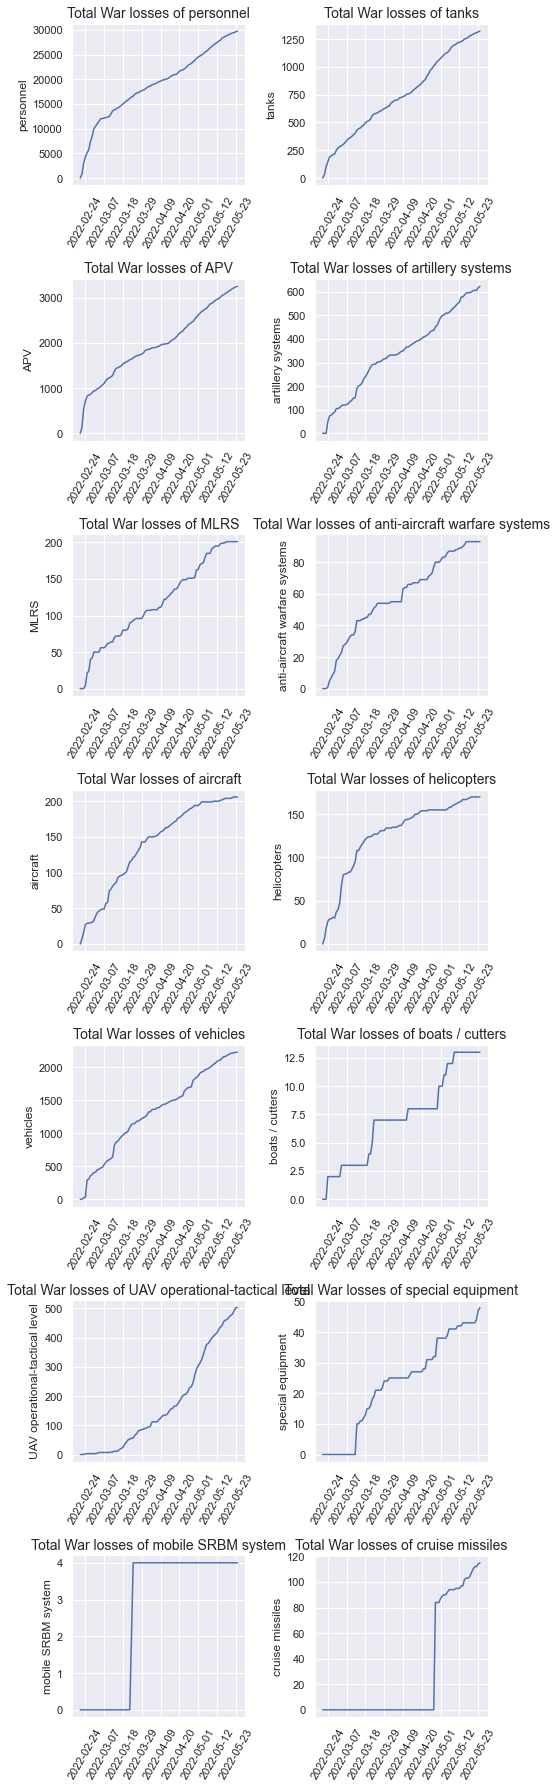

In [270]:
draw(df, 7, 2, len(df), 'Total')

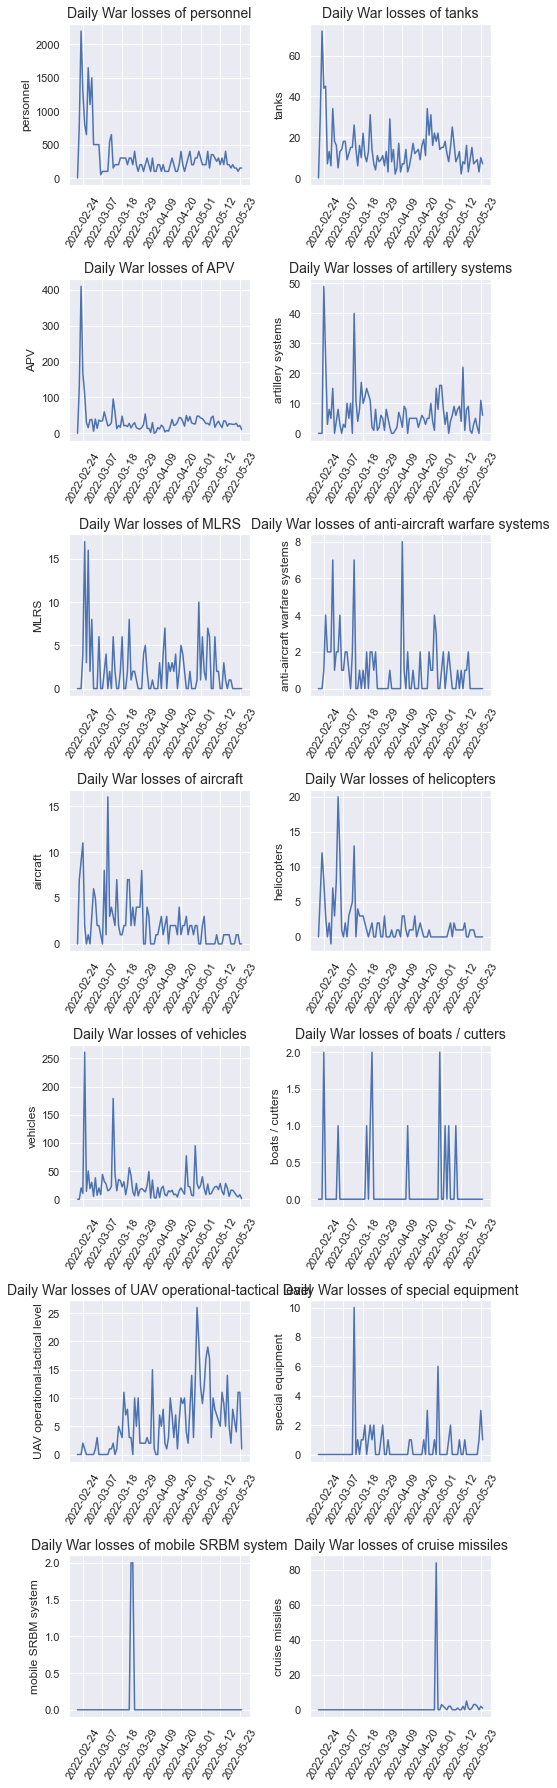

In [271]:
draw(daily_df, 7, 2, len(daily_df), 'Daily')

## Boxplot
Let's take a look at boxplots of daily losses.

As we see, the scale of features is different and it is quite hard to describe each feature on 1 plot.

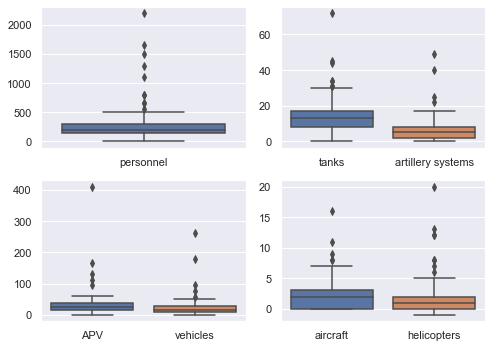

In [272]:
fig, axs = plt.subplots(2, 2)

sns.boxplot(data=daily_df.iloc[:, :1], ax=axs[0, 0])
sns.boxplot(data=daily_df.iloc[:, [1, 3]], ax=axs[0, 1])
sns.boxplot(data=daily_df.iloc[:, [2, 8]], ax=axs[1, 0])
sns.boxplot(data=daily_df.iloc[:, 6:8], ax=axs[1, 1])

fig.set_figheight(5)
fig.set_figwidth(7)

plt.tight_layout()

## Hypothesis testing

Let's conduct 2 hypothesis tests.
<br><br><br>
**Firstly** we check whether sample mean $\bar{x}$ equals to intuitive mean of the population $\mu = 300$.

$H_0: \bar{x} = 300$

$H_1: \bar{x} \neq 300$

In [273]:
print('Sample mean =', daily_df.iloc[1:, :]['personnel'].mean())

mu = 300
ttest, p_value = stats.ttest_1samp(daily_df.iloc[1:, :]['personnel'], mu)
p_value

Sample mean = 323.3695652173913


0.514512263858723

Under significance level $\alpha = 0.05$ we can't reject null hypotheis that $\bar{x} = 300$
<br><br><br><br>
Now let's check whether the data is normally distributed. Since here:
<br><br><br>
$H_0$: personnel losses $X \sim \mathcal{N}(\mu, \sigma^{2})$

$H_1$: personnel losses $X \neq \mathcal{N}(\mu, \sigma^{2})$

In [274]:
ttest, p_value = stats.shapiro(daily_df.iloc[1:, :]['personnel'])

p_value

1.6115482836002656e-14

Under significance level $\alpha = 0.05$ we **can reject** null hypotheis and claim that **personel losses is not normally distributed**.

## Heatmap
Let's take a look at correlation between different losses.

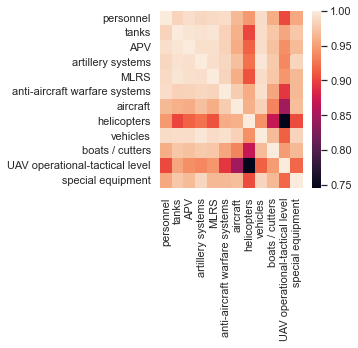

In [275]:
plt.figure(figsize=(5, 5))
sns.heatmap(df.iloc[:, :-2].corr())
plt.tight_layout()

## War duration (in hours)

In [276]:
war_duration_hours = round((pd.to_datetime('today') - df.index[0]) / pd.Timedelta(hours=1), 2)

print(f'War is going on {len(df)} days ({war_duration_hours} hours)')

War is going on 93 days (2229.08 hours)


## ARIMA model
### Parameters tunning

We choose dead soldires as the object for forecasting. First we need to choose 3 main parameters $p, q, r$ for the ARIMA model.

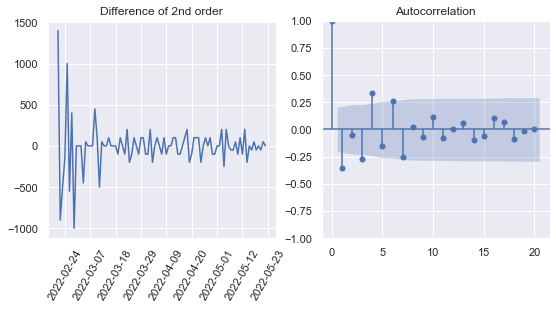

In [277]:
def plot_autocorrelation():
    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.plot(df['personnel'].diff().diff().dropna())
    ax1.set_title('Difference of 2nd order')

    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.set_xticklabels(x_ticks, rotation=60)

    plot_acf(df['personnel'].diff().diff().dropna(), ax=ax2)

    fig.set_figheight(4)
    fig.set_figwidth(9)

    plt.show()

plot_autocorrelation()

In [278]:
a_test = adfuller(df['personnel'])
print('p-value:', a_test[1])

a_test = adfuller(df['personnel'].diff().dropna())
print('p-value:', a_test[1])

a_test = adfuller(df['personnel'].diff().diff().dropna())
print('p-value:', a_test[1])

p-value: 0.44267994924522963
p-value: 0.0003958540034099474
p-value: 1.071727792201968e-06


Here we see that under significance level $\alpha$ the order of differencing $d = 2$.

$p$, the most significant lag, is 1.

$q$, the number of lags, crossing the threshold is 3.

Therefore we can construct **ARIMA(p=1, d=2, q=3)** model.

## Model fitting

In [279]:
arima = ARIMA(df['personnel'], order=(1, 2, 3)).fit()
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:              personnel   No. Observations:                   93
Model:                 ARIMA(1, 2, 3)   Log Likelihood                -618.955
Date:                Fri, 27 May 2022   AIC                           1247.910
Time:                        21:04:43   BIC                           1260.464
Sample:                    02-24-2022   HQIC                          1252.975
                         - 05-27-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000      0.005   -182.414      0.000      -1.011      -0.989
ma.L1          1.0264      0.108      9.544      0.000       0.816       1.237
ma.L2         -0.4805      0.097     -4.936      0.0

## Prediction curve

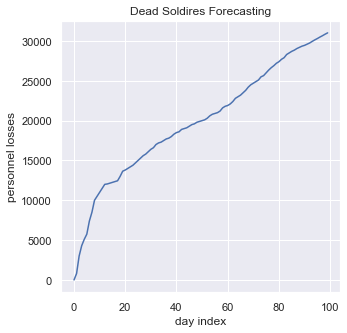

In [280]:
def plot_forecast(forecasting):
    plt.figure(figsize=(5, 5))
    plt.plot(range(len(forecasting)), forecasting)
    plt.xlabel('day index')
    plt.ylabel('personnel losses')
    plt.title('Dead Soldires Forecasting')
    plt.show()

def forecast_concat(model, days: int):
    y_hat = model.forecast(days).values
    y = df['personnel'].values

    return np.concatenate([y, y_hat])

forecasting = forecast_concat(arima, 7)
plot_forecast(forecasting)

## Model testing

In order to test our model, we create it based on first 60 days. We know real values of deaths for the next $n - 60$ days. After that we forecast deaths and compute **RMSE, MAE**.

In [281]:
arima = ARIMA(df['personnel'][:60], order=(1, 2, 3)).fit()

y_hat = arima.forecast(33).values
y = df['personnel'][60:].values

print('MAE:', mean_absolute_error(y, y_hat))
print('RMSE:', mean_squared_error(y, y_hat, squared=False))
print('Correlation between real and predicted variables:', np.corrcoef(y_hat, y)[0, 1])

MAE: 1926.4698985071261
RMSE: 2163.587365152777
Correlation between real and predicted variables: 0.9963214482897145


We got good enough errors, which are the indicators, that our model can be used for prediction the number of dead soldires.

## Write obtained results in the csv file

In [282]:
def write_csv(file, forecasting):
    forecasting = forecasting.astype(int)
    data = [[i, y_hat] for i, y_hat in enumerate(forecasting)]

    with open(file, 'w') as f:
        write = csv.writer(f)
        write.writerow(['day index', 'deaths'])
        write.writerows(data)

In [283]:
# write_csv('losses.csv', forecasting)

## Conclusion
Russian troops should become more conscious.They will join to the part of sad statistics otherwise. Ukraine doesn't want to kill, but Ukraine wants to defend it's people. Get away of our country!

Русский военный корабль, иди нах*й
#### Glory to Ukraine!
#### Слава Україні!

## Data source
General Staff of the Armed Forces of Ukraine
 
https://www.facebook.com/GeneralStaff.ua

## Credits
© Mykhailo-Markiian Tsalyk

https://www.linkedin.com/in/markiian-tsalyk-193758224/